In [59]:
import os
import json
from dotenv import load_dotenv
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openai import OpenAI
import tiktoken

from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import sacrebleu

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('API_KEY')

# Introduction
# Technical Translation: English to Spanish, GPT 4
---

## Description
The USFS AirFire group maintains systems that forecasters use to create Smoke Outlooks, i.e. wildfire smoke forecasts. These are initially written in English. Then they are auto-translated into Spanish with ChatGPT. Finally, the translations are manually edited by a native speaker. The goal of this project is to use our corpus of existing outlooks and translations to train a ChatGPT model for improved translations. A simple user interface will also be needed to allow professional translators to compare translations using the trained and untrained models.

## Goals
We hope to reduce the amount of time staff spend translating outlooks while maintaining high quality translations. If all goes well, we will end up with: 1) a trained model for improved translations; 2) tailored prompts; and 3) a small user interface to test ChatGPT models. If successful, this approach will be used to support translation targets other than Spanish.

# Part 1
---
## Data Preparation
The following data contains historical smoke and fire forecasts that have been translated from English to Spanish. These translations have been verified by a translator.  

In [3]:
location_df = pd.read_csv('./data/Location_Forecast_translations.csv')
collection_df = pd.read_csv('./data/Collection_Forecast_translations.csv')

In [4]:
location_df.head()

,forecast_summary,today_comment,tomorrow_comment,extended_comment,forecast_summary_es,today_comment_es,tomorrow_comment_es,extended_comment_es
0,"Noticeable smoke, some improvement late aftern...",Smoky to start the day. A few hours of better ...,"UNHEALTHY conditions in the morning, should in...",Smoke likely to be in the air this weekend.,"Humo notable, alguna mejora a última hora de l...",Ahumado para comenzar el día. Se esperan unas ...,"Condiciones INSALUBRES por la mañana, deberían...",Es probable que haya humo en el aire este fin ...
1,"GOOD air quality overall, potential for brief ...",NaN,MODERATE air quality based on regional forecas...,Smoke likely to be in the air this weekend.,"Calidad del aire BUENO en general, con potenci...",NaN,Calidad del aire MODERADA según el pronóstico ...,Es probable que haya humo en el aire este fin ...
2,"Smoke will linger, brief improvement late afte...",Smoky to start the day. A few hours of better ...,Heavy smoke in the morning Thursday.,Smoke likely to be in the air this weekend.,"El humo persistirá, breve mejora al final de l...",Ahumado para comenzar el día. Se esperan unas ...,Humo denso en la mañana del jueves.,Es probable que haya humo en el aire este fin ...
3,"Noticeable smoke, some improvement late aftern...",Smoky to start the day. A few hours of better ...,"UNHEALTHY conditions in the morning, should in...",Smoke likely to be in the air this weekend.,"Humo notable, alguna mejora a última hora de l...",Ahumado para comenzar el día. Se esperan unas ...,"Condiciones INSALUBRES por la mañana, deberían...",Es probable que haya humo en el aire este fin ...
4,"GOOD air quality overall, potential for brief ...",NaN,MODERATE air quality based on regional forecas...,Smoke likely to be in the air this weekend.,"Calidad del aire BUENA en general, con potenci...",NaN,Calidad del aire MODERADA según el pronóstico ...,Es probable que haya humo en el aire este fin ...


In [5]:
collection_df.head()

,fire_statement_json,smoke_statement_json,special_statement_json,fire_statement_json_es,smoke_statement_json_es,special_statement_json_es
0,"The Yellow Lake Fire is at 16,053 acres and 10...",A stable airmass means a little more smoke cou...,The Northern Park has closed the SW entrance. ...,"El incendio de Yellow Lake abarca 16,053 acres...",Una masa de aire estable significa que un poco...,El Parque del Norte ha cerrado la entrada SO. ...
1,"The Yellow Lake Fire is at 16,053 acres and 10...",A stable airmass means a little more smoke cou...,The Northern Park has closed the SW entrance. ...,"El incendio de Yellow Lake abarca 16,053 acres...",Una masa de aire estable significa que un poco...,El Parque del Norte ha cerrado la entrada SO. ...
2,"The Yellow Lake Fire is at 16,053 acres and 10...",A stable airmass means a little more smoke cou...,The Northern Park has closed the SW entrance. ...,"El incendio de Yellow Lake está en 16,053 acre...",Una masa de aire estable significa que un poco...,El Parque del Norte ha cerrado la entrada SO. ...
3,"Fire behavior is currently minimal, yet red fl...",Smoke production could increase today with con...,RED FLAG WARNING in effect from 1100 Thursday ...,El comportamiento del fuego es actualmente mín...,La producción de humo podría aumentar hoy debi...,ADVERTENCIA DE BANDERA ROJA en efecto desde la...
4,The Shoe Fire fire is currently estimated at 4...,Communities east of the Shoe Fire should see G...,RED FLAG WARNING in effect from 1100 Thursday ...,El incendio Shoe Fire se estima actualmente en...,Las comunidades al este del Incendio Shoe debe...,AVISO DE BANDERA ROJA en efecto desde las 11:0...


In [6]:
translation_prompt = """
You are an official English to Spanish translator translating air quality forecasts
from English into Spanish. Use the following word-translation pairs when translating:

GOOD => BUENO
MODERATE => MODERADA
USG => IGS
UNHEALTHY => INSALUBRE
VERY UNHEALTHY => MUY INSALUBRE
HAZARDOUS => PELIGROSA

Translate the following air quality discussion into Spanish:"""

In [ ]:
def prepare_location_forecast(location_data, translation_prompt, test_size=0.2, random_state=42):
    train_data, test_data = train_test_split(location_data, test_size=test_size, random_state=random_state)
    
    location_training_data = []
    
    for _, row in train_data.iterrows():
        english_text = f"""
Forecast Summary: {row['forecast_summary']}
Today's Comment: {row['today_comment']}
Tomorrow's Comment: {row['tomorrow_comment']}
Extended Comment: {row['extended_comment']}"""
    
        spanish_text = f"""
Resumen del Pronóstico: {row['forecast_summary_es']}
Comentario de Hoy: {row['today_comment_es']}
Comentario de Mañana: {row['tomorrow_comment_es']}
Comentario Extendido: {row['extended_comment_es']}"""
    
        location_training_data.append({
            'messages': [
                {'role': 'system', 'content': f'{translation_prompt}'}, 
                {'role': 'user', 'content': f'{english_text}'}, 
                {'role': 'assistant', 'content': f'{spanish_text}'}
            ]
        })

    location_testing_data = []
    
    for _, row in test_data.iterrows():
        english_text = f"""
Forecast Summary: {row['forecast_summary']}
Today's Comment: {row['today_comment']}
Tomorrow's Comment: {row['tomorrow_comment']}
Extended Comment: {row['extended_comment']}"""
    
        spanish_text = f"""
Resumen del Pronóstico: {row['forecast_summary_es']}
Comentario de Hoy: {row['today_comment_es']}
Comentario de Mañana: {row['tomorrow_comment_es']}
Comentario Extendido: {row['extended_comment_es']}"""
    
        location_testing_data.append({
            'english_text': english_text,
            'spanish_text': spanish_text
        })

    return location_training_data, location_testing_data

In [7]:
def prepare_collection_forecast(collection_data, translation_prompt, test_size=0.2, random_state=42): 
    train_data, test_data = train_test_split(collection_data, test_size=test_size, random_state=random_state)

    collection_training_data = []
    
    for _, row in train_data.iterrows():
        english_text = f"""
Fire Statement: {row['fire_statement_json']}
Smoke Statement: {row['smoke_statement_json']}
Special Statement: {row['special_statement_json']}"""

        spanish_text = f"""
Declaración del Incendio: {row['fire_statement_json_es']}
Declaración del Humo: {row['smoke_statement_json_es']}
Declaración Especial: {row['special_statement_json_es']}"""

        collection_training_data.append({
            'messages': [
                {'role': 'system', 'content': f'{translation_prompt}'}, 
                {'role': 'user', 'content': f'{english_text}'}, 
                {'role': 'assistant', 'content': f'{spanish_text}'}
            ]
        })

    collection_testing_data = []
    
    for _, row in test_data.iterrows():
        english_text = f"""
Fire Statement: {row['fire_statement_json']}
Smoke Statement: {row['smoke_statement_json']}
Special Statement: {row['special_statement_json']}"""

        spanish_text = f"""
Declaración del Incendio: {row['fire_statement_json_es']}
Declaración del Humo: {row['smoke_statement_json_es']}
Declaración Especial: {row['special_statement_json_es']}"""

        collection_testing_data.append({
            'english_text': english_text,
            'spanish_text': spanish_text
        })

    return collection_training_data, collection_testing_data


In [8]:
def write_to_jsonl(datasets, file_name):
    output_path = f'{file_name}.jsonl'
    with open(output_path, 'w', encoding='utf-8') as file:
        for dataset in datasets:
            for entry in dataset:
                json.dump(entry, file)
                file.write('\n')
    print('File saved at:', output_path)
    return output_path

In [10]:
location_training_data, location_testing_data = prepare_location_forecast(location_df, translation_prompt)
collection_training_data, collection_testing_data = prepare_collection_forecast(collection_df, translation_prompt)

training_datasets = [location_training_data, collection_training_data]
testing_datasets = [location_testing_data, collection_testing_data]

combined_training_dataset_path = write_to_jsonl(training_datasets, 'combined_training_dataset')
combined_testing_dataset_path = write_to_jsonl(testing_datasets, 'combined_testing_dataset')

File saved at: combined_training_dataset.jsonl
File saved at: combined_testing_dataset.jsonl


# Part 2
---
## Data Validation
Now that the training data has been validated, validation procedures ([found here](https://cookbook.openai.com/examples/chat_finetuning_data_prep)) will be used to check for format errors, provide basic statistics, and estimate token counts for fine-tuning costs.

In [11]:
def load_dataset(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as file:
        dataset = [json.loads(line) for line in file]

    return dataset

combined_training_dataset = load_dataset(combined_training_dataset_path)
combined_testing_dataset = load_dataset(combined_testing_dataset_path)

print('Number of training examples:', len(combined_training_dataset))
print('Number of testing examples:', len(combined_testing_dataset))

Number of training examples: 800
Number of testing examples: 200


In [15]:
def check_format(dataset):
    # Format error checks
    format_errors = defaultdict(int)
    
    for ex in dataset:
        if not isinstance(ex, dict):
            format_errors["data_type"] += 1
            continue
            
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue
            
        for message in messages:
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1
            
            if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
                format_errors["message_unrecognized_key"] += 1
            
            if message.get("role", None) not in ("system", "user", "assistant", "function"):
                format_errors["unrecognized_role"] += 1
                
            content = message.get("content", None)
            function_call = message.get("function_call", None)
            
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1
        
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1
    
    if format_errors:
        print("Found errors:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
    else:
        print("No errors found")
        
check_format(combined_training_dataset)
# missing messages in testing is fine
check_format(combined_testing_dataset)

No errors found
Found errors:
missing_messages_list: 200


## Token Counting and Cost Utilities

In [16]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [17]:
def warnings_counts_cost(dataset):
    # Warnings and tokens counts
    n_missing_system = 0
    n_missing_user = 0
    n_messages = []
    convo_lens = []
    assistant_message_lens = []
    
    for ex in dataset:
        messages = ex["messages"]
        if not any(message["role"] == "system" for message in messages):
            n_missing_system += 1
        if not any(message["role"] == "user" for message in messages):
            n_missing_user += 1
        n_messages.append(len(messages))
        convo_lens.append(num_tokens_from_messages(messages))
        assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
        
    print("Num examples missing system message:", n_missing_system)
    print("Num examples missing user message:", n_missing_user)
    print_distribution(n_messages, "num_messages_per_example")
    print_distribution(convo_lens, "num_total_tokens_per_example")
    print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
    n_too_long = sum(l > 16385 for l in convo_lens)
    print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")

    # Pricing and default n_epochs estimate
    MAX_TOKENS_PER_EXAMPLE = 16385
    
    TARGET_EPOCHS = 3
    MIN_TARGET_EXAMPLES = 100
    MAX_TARGET_EXAMPLES = 25000
    MIN_DEFAULT_EPOCHS = 1
    MAX_DEFAULT_EPOCHS = 25
    
    n_epochs = TARGET_EPOCHS
    n_train_examples = len(dataset)
    if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
        n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
    elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
        n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)
    
    n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
    print(f"\nDataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
    print(f"By default, you'll train for {n_epochs} epochs on this dataset")
    print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")


warnings_counts_cost(combined_training_dataset)

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 167, 991
mean / median: 301.30625, 246.0
p5 / p95: 183.0, 493.4000000000001

#### Distribution of num_assistant_tokens_per_example:
min / max: 36, 543
mean / median: 119.35375, 88.5
p5 / p95: 46.0, 237.4000000000001

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning

Dataset has ~241045 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~723135 tokens


# Part 3
---
## Model Tuning

In [20]:
client = OpenAI()

In [21]:
file_response = client.files.create(
    file=open(combined_training_dataset_path, "rb"),
    purpose="fine-tune"
)
file_id = training_file_response.id

In [22]:
fine_tune_job = client.fine_tuning.jobs.create(
    seed=42,
    training_file=file_id,
    model='gpt-4o-mini-2024-07-18',
    method={
        'type': 'supervised',
        'supervised': {
            'hyperparameters': {
                'batch_size': 'auto',
                'learning_rate_multiplier': 'auto',
                'n_epochs': 'auto'
            }
        }
    }
)

print(f"Fine-tuning job created with ID: {fine_tune_job.id}")

Fine-tuning job created with ID: ftjob-szryBNBIzUT6qRZvrPSGw6sF


In [85]:
fine_tune_response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=fine_tune_job.id, limit=2500)
event_data = fine_tune_response.data
event_data.reverse()

model_training_loss = []
for event in event_data:
    if event.data and 'train_loss' in event.data:
        model_training_loss.append(event.data['train_loss'])

def moving_average(data, window_size=4):
    i = 0
    m_avg = []
    while i < (len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = round(sum(window) / window_size, 2)
        m_avg.append(window_average)
        i += 1
    
    return m_avg

model_training_loss_smooth = moving_average(model_training_loss, window_size=14)

In [37]:
# Retrieve the state of a fine-tune
fine_tune_response = client.fine_tuning.jobs.retrieve(fine_tune_job.id)
fine_tuned_model_name = fine_tune_response.fine_tuned_model
print(fine_tuned_model_name)

ft:gpt-4o-mini-2024-07-18:airfire::AvdsGrLa


# Part 4
---
## Model Testing

In [25]:
testing_data = []
with open(combined_testing_dataset_path, "r") as file:
    for line in file:
        testing_data.append(json.loads(line.strip()))

print(f"Loaded {len(testing_data)} testing records.")

Loaded 200 testing records.


In [40]:
predictions = []
for test_instance in testing_data:
    english_text = test_instance['english_text']  # Input
    expected_output = test_instance['spanish_text']  # Ground truth
    
    # Generate prediction using the fine-tuned model
    response = client.chat.completions.create(
        model=fine_tuned_model_name,
        messages=[
            {"role": "system", "content": translation_prompt},
            {"role": "user", "content": english_text}
        ]
    )
    prediction = response.choices[0].message.content
    predictions.append({
        'input': english_text,
        'expected_output': expected_output,
        'predicted_output': prediction
    })

In [51]:
meteor_scores = [
    meteor_score(
        [word_tokenize(pred['expected_output'])],  # Tokenized reference
        word_tokenize(pred['predicted_output'])   # Tokenized hypothesis
    )
    for pred in predictions
]

In [54]:
meteor_scores

[0.9384668801357973,
 0.9999794989544467,
 0.9727430555555557,
 0.9999985422740525,
 0.9537792973150613,
 0.8913881674208185,
 0.8998951205230933,
 0.8892382624094755,
 0.832454648526077,
 0.9076435797261102,
 0.8853048921239491,
 0.9999954788773148,
 0.9790393466123434,
 0.9870039932366803,
 0.9999921875,
 0.9999990931646378,
 0.9649234693877551,
 0.9018804200170463,
 0.9999530428249437,
 0.8763646163020047,
 0.9069872958257714,
 0.9402296423498169,
 0.7907948248328929,
 0.9838536293573528,
 0.9577053584482673,
 0.8942483614450347,
 0.9157137061347536,
 0.9981882048437789,
 0.8737244897959183,
 0.9223944324905863,
 0.9420175783812147,
 0.9999901289163524,
 0.9999915709974881,
 0.8968203721290141,
 0.8968207117557767,
 0.9341692209655428,
 0.9708127112652185,
 0.9649234693877551,
 0.9621773967318886,
 0.8797881600649766,
 0.863280276816609,
 0.9653413089373681,
 0.9999794989544467,
 0.9627438088976551,
 0.9487906474134646,
 0.8936356453759149,
 0.7889886437957073,
 0.9598139105902778,


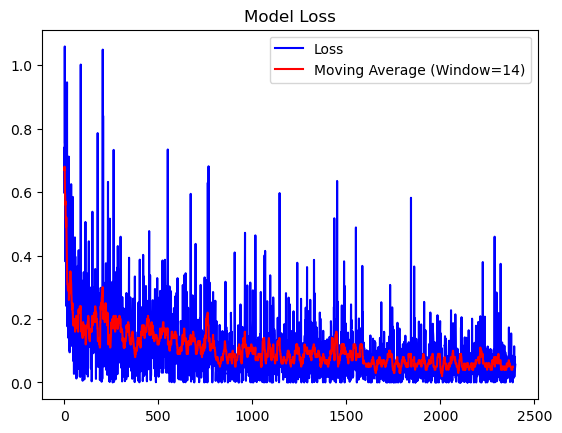

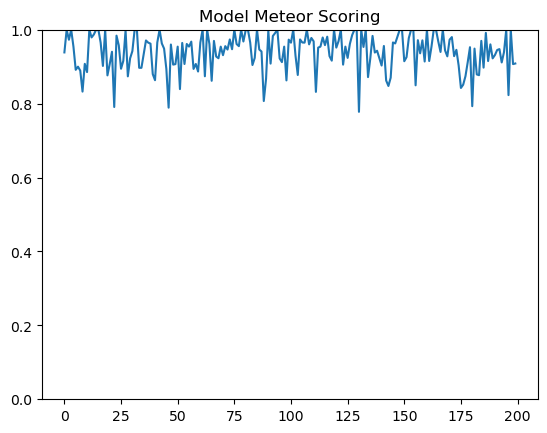

In [86]:
plt.plot(range(len(model_training_loss)), model_training_loss, label='Loss', color='b')
plt.plot(range(len(model_training_loss_smooth)), model_training_loss_smooth, label='Moving Average (Window=14)', color='r')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(range(len(meteor_scores)), meteor_scores,)
plt.ylim(0, 1)
plt.title('Model Meteor Scoring')
plt.show()